    В данном ноутбуке исследуются возможности гибридной модели с использованием эмбеддингов FasttText. Эмбеддинги были получены с BPE и в сравнении со стандартным заполнением layers.Embedding прироста в качестве не было обнаружено.

`(train 0.5, val 0.47, test 0.48)`
`(эпох 100, батч 200)`

### Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import os
import sys

import random
random.seed(42)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')
sys.path.insert(0, './src/')

import re
import pandas as pd
import numpy as np
import joblib
import csv
from keras.preprocessing import sequence

sys.path.append('./src')
from PreprocInput import preproc_

import bpe
from tqdm import tqdm_notebook

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPool1D, Embedding, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

from gensim.models.fasttext import FastText as FT_gensim
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models import TfidfModel, KeyedVectors
from gensim.test.utils import datapath

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### Set GPU

In [4]:
with K.tf.device('/GPU:0'):
    config = tf.compat.v1.ConfigProto() 
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.compat.v1.Session(config=config)
    K.set_session(session)

### Secondary functions

In [5]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()    

# Load dataset and preproc

In [6]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


### Prepare 1-st Input: Tensor with Tokens' Id to be passed on Embed Layer

In [7]:
bpe = bpe.Encoder.load('./same_/bpe_tokenizer_v2.h5')

In [8]:
def tokens_to_ids(encoder, x):
    x_toks = []
    for i in tqdm_notebook(range(len(x)), total=len(x)):
        encoder.tokenize(x[i])
        x_toks.append(next(encoder.transform([x[i]]))[1:-1])
        
    max_len = max(map(len, x_toks))
    X_arr = np.zeros((len(x_toks), max_len), dtype='int32')
    for i, s in enumerate(x_toks):
        X_arr[i, 0:len(s)] = s
        
    return X_arr

X_toks = tokens_to_ids(bpe, data.seq.values)

### Prepare 2-nd Input: Create one-hot encoded vectors using the `char_indices` map

In [9]:
MAXCHARSLEN = max(map(len, data.seq.values))
MAXSEQLEN = max(map(len, X_toks))

chars = sorted(list(set(data.seq.values[0])))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [10]:
X, y = preproc_.get_input_array(data.seq.values, data.label.values, MAXCHARSLEN, chars, char_indices)
X.shape, y.shape

((3351352, 30, 4), (3351352, 4))

In [11]:
X_toks_train, X_toks_test, y_train, y_test = train_test_split(X_toks, y, 
                                                              random_state=42, shuffle=True, test_size=0.1)
X_train, X_test, _, _ = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.1)

## Gensim FastText

`(train dasttext)`

`(load fasttext)`

In [12]:
fw2vec = './same_/bpe_ft_500.vec'
w2vec = KeyedVectors.load_word2vec_format(fw2vec)

In [13]:
w2vec.wv.similar_by_word('a')

[('aa', 0.5441487431526184),
 ('aaca', 0.5310763716697693),
 ('aga', 0.5125366449356079),
 ('aatg', 0.5102294683456421),
 ('ata', 0.508975625038147),
 ('agta', 0.5002345442771912),
 ('atga', 0.49688899517059326),
 ('aac', 0.4963187277317047),
 ('acaa', 0.4957149624824524),
 ('aaag', 0.4953441023826599)]

In [14]:
vocab_bpe = bpe.bpe_vocab
vocab_bpe.update(bpe.word_vocab)

## Generate Embeding Matrix: Get FT Embeddings without TFIDF weighting

In [15]:
embedding_matrix = np.zeros((bpe.vocab_size+1, w2vec.vector_size))
for i, vec in enumerate(w2vec.wv.vectors):
    embedding_matrix[vocab_bpe[w2vec.index2word[i]]] = vec

In [16]:
embedding_matrix.shape

(501, 300)

# Build and train model

In [17]:
def get_model(vocab_size, n_classes, seq_len_emb, seq_len_chars):
    
    inp = Input(shape =(seq_len_emb,), name='Input1')
    emb = Embedding(vocab_size, 300, name='BPE_emb')(inp)
    x = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2), name='BiLSTM_0')(emb)
    ###
    inp2 = Input(shape = (seq_len_chars, n_classes), name='Input2')
    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="relu",
                name='Conv1d_0')(inp2)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-1')(y)
    y = BatchNormalization(name='BatchNorm-1')(y)
        
    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="relu",
                name='Conv1d_1')(inp2)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-1')(y)
    y = BatchNormalization(name='BatchNorm-1')(y)    
    y = Dropout(0.2, name='Dropout_0.2')(y)
    y = Flatten(name='Flatten')(y)
    ###
    comb = Concatenate(name='Concat')([x,y])

    z = Dense(128, activation='tanh', name='Dense_1024_0')(comb)  
    z = Dense(n_classes, activation='softmax', name='Dense_NCLASS')(z)
    model = Model(inputs=[inp, inp2], outputs=z)
    
    model.summary()
    
    return model

In [18]:
VOCAB_SIZE = embedding_matrix.shape[0]


model = get_model(vocab_size = VOCAB_SIZE, 
                  n_classes=len(chars), 
                  seq_len_emb=MAXSEQLEN, 
                  seq_len_chars=MAXCHARSLEN)

embedding = model.get_layer('BPE_emb')
embedding.set_weights([embedding_matrix])
embedding.trainable = False

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input2 (InputLayer)             (None, 30, 4)        0                                            
__________________________________________________________________________________________________
Conv1d_1 (Conv1D)               (None, 28, 128)      1664        Input2[0][0]                     
__________________________________________________________________________________________________
MaxPool1d-1 (MaxPooling1D)      (None, 14, 128)      0           Conv1d_1[0][0]                   
__________________________________________________________________________________________________
Input1 (InputLayer)  

In [ ]:
path = './same_/bilstm_emb_fasttext.h5'

callbacks = [EarlyStopping(patience=12, monitor='val_loss'),
             ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit([X_toks_train, X_train], y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

Instructions for updating:
Use tf.cast instead.
Train on 2412972 samples, validate on 603244 samples
Epoch 1/160
2412972/2412972 [==============================] - 626s 259us/step - loss: 1.3323 - acc: 0.3554 - val_loss: 1.3047 - val_acc: 0.3757

Epoch 00001: val_loss improved from inf to 1.30465, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 2/160
2412972/2412972 [==============================] - 620s 257us/step - loss: 1.3026 - acc: 0.3769 - val_loss: 1.2933 - val_acc: 0.3844

Epoch 00002: val_loss improved from 1.30465 to 1.29326, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 3/160
2412972/2412972 [==============================] - 619s 257us/step - loss: 1.2914 - acc: 0.3872 - val_loss: 1.2854 - val_acc: 0.3926

Epoch 00003: val_loss improved from 1.29326 to 1.28544, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 4/160
2412972/2412972 [==============================] - 620s 257us/step - loss: 1.2822 - acc: 0.3959 - val_loss: 1.2788 - val_acc: 0.3984

Epoch 0000

Epoch 33/160
2412972/2412972 [==============================] - 630s 261us/step - loss: 1.2073 - acc: 0.4573 - val_loss: 1.2263 - val_acc: 0.4461

Epoch 00033: val_loss improved from 1.22730 to 1.22626, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 34/160
2412972/2412972 [==============================] - 623s 258us/step - loss: 1.2056 - acc: 0.4595 - val_loss: 1.2252 - val_acc: 0.4473

Epoch 00034: val_loss improved from 1.22626 to 1.22523, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 35/160
2412972/2412972 [==============================] - 624s 259us/step - loss: 1.2039 - acc: 0.4602 - val_loss: 1.2243 - val_acc: 0.4481

Epoch 00035: val_loss improved from 1.22523 to 1.22428, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 36/160
2412972/2412972 [==============================] - 640s 265us/step - loss: 1.2025 - acc: 0.4615 - val_loss: 1.2232 - val_acc: 0.4490

Epoch 00036: val_loss improved from 1.22428 to 1.22321, saving model to ./same_/bilstm_emb_fasttext.h5


Epoch 66/160
2412972/2412972 [==============================] - 1021s 423us/step - loss: 1.1705 - acc: 0.4845 - val_loss: 1.2002 - val_acc: 0.4692

Epoch 00066: val_loss improved from 1.20093 to 1.20025, saving model to ./same_/bilstm_emb_fasttext.h5
Epoch 67/160
1044200/2412972 [===========>..................] - ETA: 8:37 - loss: 1.1685 - acc: 0.4861

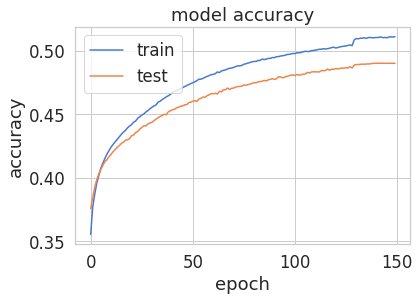

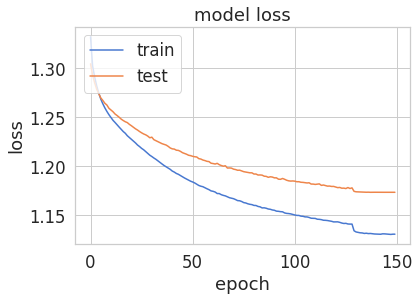

In [22]:
plot_metrics(history)

# OOB Validation

In [ ]:
model = load_model(path)

In [23]:
y_pred = model.predict([X_toks_test, X_test])
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

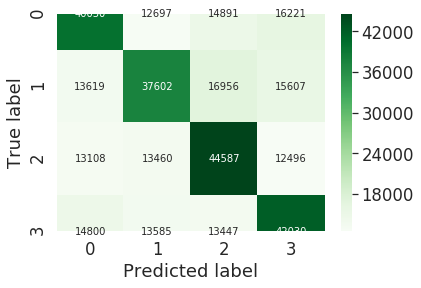

In [25]:
confusion_matrix_heatmap(y_true, y_pred)

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.48      0.48     83839
           1       0.49      0.45      0.47     83784
           2       0.50      0.53      0.51     83651
           3       0.49      0.50      0.49     83862

    accuracy                           0.49    335136
   macro avg       0.49      0.49      0.49    335136
weighted avg       0.49      0.49      0.49    335136

